In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import seaborn
seaborn.set_style('ticks')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller 
from fracdiff import Fracdiff, StationaryFracdiff

## Coefficient

In [2]:
X = np.array([1., 0., 0., 0., 0., 0.]).reshape(-1, 1)

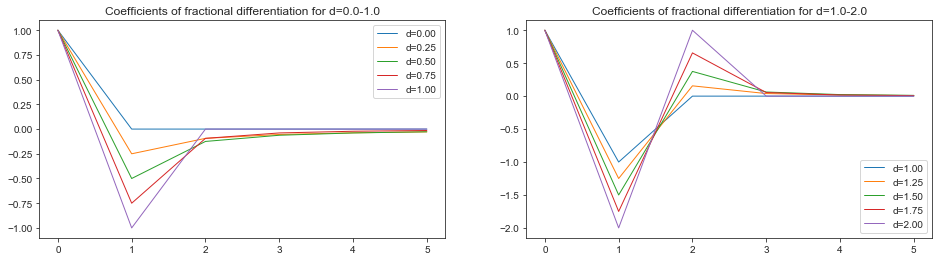

In [3]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.title('Coefficients of fractional differentiation for d=0.0-1.0')
for order in np.linspace(0.0, 1.0, 5):
    Xd = Fracdiff(order, window=-1).transform(X)
    plt.plot(Xd, label=f'd={order:.2f}', linewidth=1)
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Coefficients of fractional differentiation for d=1.0-2.0')
for order in np.linspace(1.0, 2.0, 5):
    Xd = Fracdiff(order, window=-1).transform(X)
    plt.plot(Xd, label=f'd={order:.2f}', linewidth=1)
plt.legend()

plt.show()

## S&P 500

In [4]:
spx = pandas_datareader.data.DataReader('^GSPC', 'yahoo', '1998-01-01', '2018-12-31')['Adj Close']
spx.head()

Date
1997-12-31    970.429993
1998-01-02    975.039978
1998-01-05    977.070007
1998-01-06    966.580017
1998-01-07    964.000000
Name: Adj Close, dtype: float64

### Plotting fracdiff

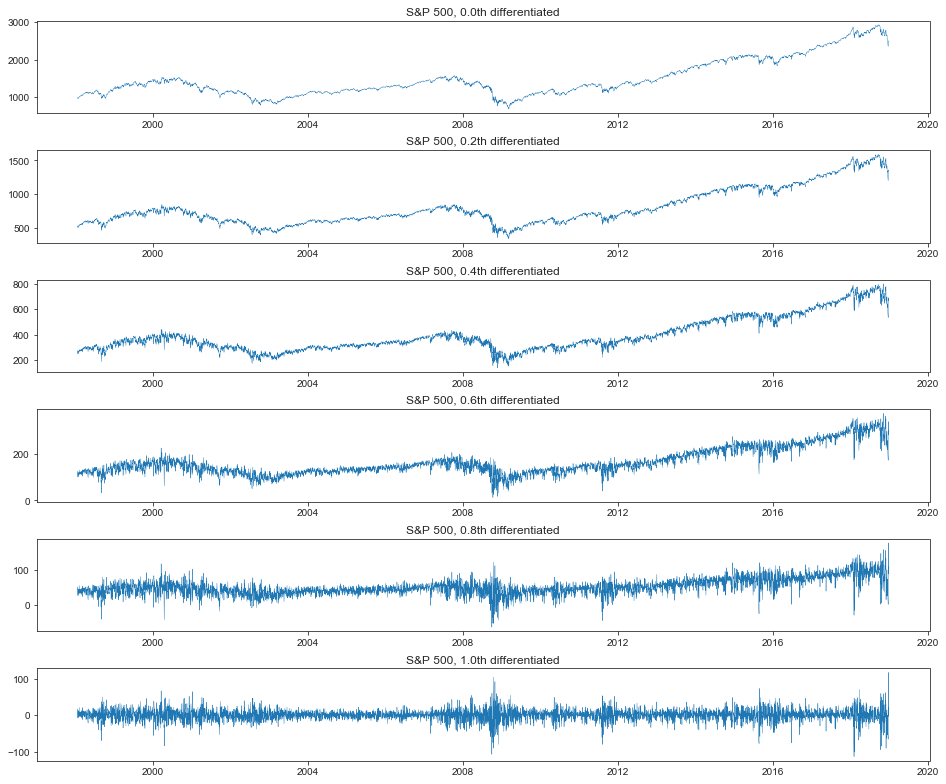

In [5]:
plt.figure(figsize=(16, 16))
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

X = spx.values.reshape(-1, 1)

for i, order in enumerate(np.linspace(0.0, 1.0, 6)):
    Xd = Fracdiff(order).transform(X)
    spxd = pd.Series(Xd[:, 0], index=spx.index)
    plt.subplot(7, 1, 2 + i)
    plt.title(f'S&P 500, {order:.1f}th differentiated')
    plt.plot(spxd, linewidth=0.4)

plt.show()

### Stationarity of fracdiff

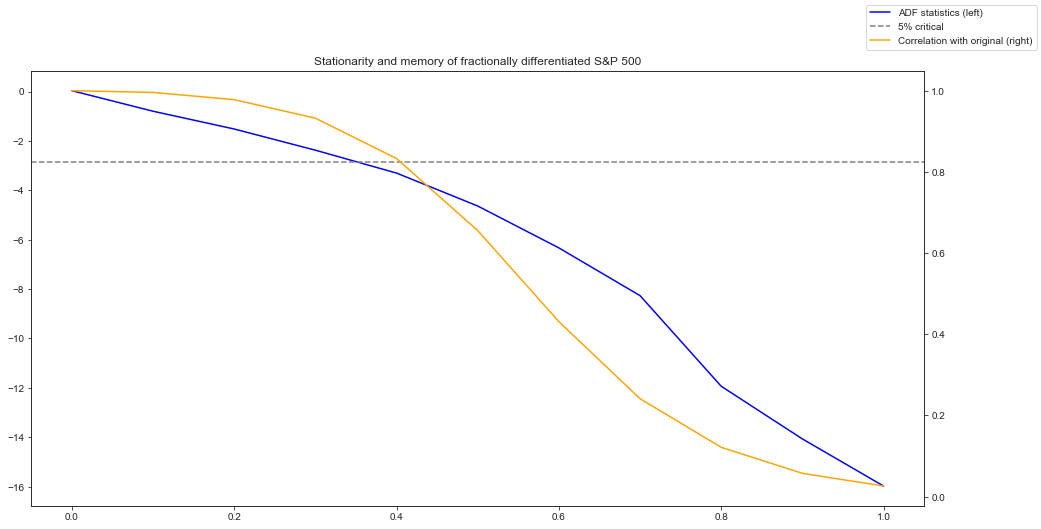

In [6]:
from statsmodels.tsa.stattools import adfuller

window = 1000

def adfstat(order):
    Xd = Fracdiff(order, window=window).transform(X)
    stat, _, _, _, _, _  = adfuller(Xd[window:, 0])
    return stat

def correlation(order):
    Xd = Fracdiff(order, window=window).transform(X)
    corr = np.corrcoef(X[window:, 0], Xd[window:, 0])[0, 1]
    return corr

# ADF statistics for orders in 0.0 - 1.0
orders = np.linspace(0.0, 1.0, 11)
stats = np.vectorize(adfstat)(orders)
corrs = np.vectorize(correlation)(orders)

# 5% critical value of stationarity
_, _, _, _, crit, _ = adfuller(X[window:, 0])
crit_5pc = crit['5%']

# plot
fig, ax_stat = plt.subplots(figsize=(16, 8))
ax_corr = ax_stat.twinx()

ax_corr.plot(orders, corrs, color='orange', label='Correlation with original (right)')
ax_stat.plot(orders, stats, color='blue', label='ADF statistics (left)')
ax_stat.axhline(y=crit_5pc, linestyle='--', color='gray', label='5% critical')

plt.title('Stationarity and memory of fractionally differentiated S&P 500')
fig.legend()
plt.show()

### Differentiation while preserving memory

In [7]:
window = 1000

statfracdiff = StationaryFracdiff(window=window, precision=.01)

Xd = statfracdiff.fit_transform(X)
order = statfracdiff.order_[0]
_, pvalue, _, _, _, _ = adfuller(Xd[window:, 0])
corr = np.corrcoef(X[window:, 0], Xd[window:, 0])[0, 1]

print(f'- Order: {order:.2f}')
print(f'- ADF pvalue: {100 * pvalue:.2f}%')
print(f'- Correlation with original: {corr:.2f}')

- Order: 0.35
- ADF pvalue: 4.58%
- Correlation with original: 0.89


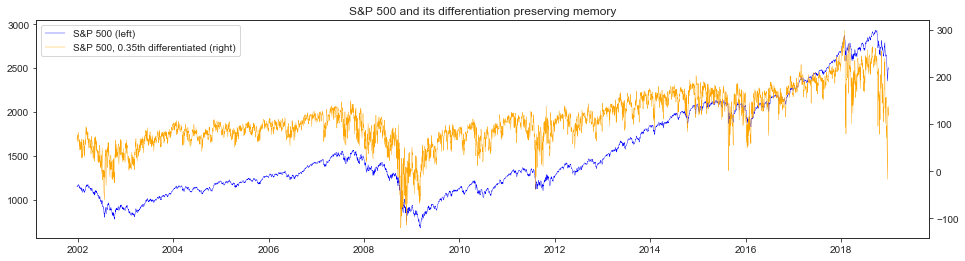

In [8]:
spxd = pd.Series(Xd[:, 0], index=spx.index)

# Plot
fig, ax_spx = plt.subplots(figsize=(16, 4))
plt.title('S&P 500 and its differentiation preserving memory')
ax_spxd = ax_spx.twinx()

plot_spx = ax_spx.plot(
    spx[window:], color='blue', linewidth=0.4,
    label='S&P 500 (left)'
)
plot_spxd = ax_spxd.plot(
    spxd[window:], color='orange', linewidth=0.4,
    label=f'S&P 500, {order:.2f}th differentiated (right)'
)
plots = plot_spx + plot_spxd
labels = [plot.get_label() for plot in plots]

ax_spx.legend(plots, labels, loc=0)
plt.show()

### Other financial data

In [9]:
tickers_yahoo = {
    'SPX': '^GSPC',
    'NKY': '^N225',
    'SHC': '^SSEC',
    'AAPL': 'AAPL',
}
tickers_fred = {
    'USDJPY': 'DEXJPUS',
    'GLD': 'GOLDPMGBD228NLBM',
    'OIL': 'DCOILWTICO',
}

prices_yahoo = pd.DataFrame({
    ticker: pandas_datareader.data.DataReader(symbol, 'yahoo', '1997-12-01', '2018-12-31')['Adj Close']
    for ticker, symbol in tickers_yahoo.items()
})
prices_fred = pd.DataFrame({
    ticker: pandas_datareader.data.DataReader(symbol, 'fred', '1997-12-01', '2018-12-31').iloc[:, 0]
    for ticker, symbol in tickers_fred.items()
})

prices = pd.concat([prices_yahoo, prices_fred], axis=1).fillna(method='ffill').loc['1998-01-02':]
prices.head()

,SPX,NKY,SHC,AAPL,USDJPY,GLD,OIL
1998-01-02,975.039978,15258.740234,1194.102051,0.504969,132.40,288.00,17.41
1998-01-05,977.070007,14956.839844,1220.473022,0.493316,133.99,284.40,16.95
1998-01-06,966.580017,14896.400391,1233.619995,0.588483,133.88,282.80,16.64
1998-01-07,964.000000,15028.169922,1244.069946,0.543813,131.70,281.60,16.91
1998-01-08,956.049988,15019.179688,1237.162964,0.565177,132.49,281.65,17.01


In [10]:
orders = np.linspace(0.0, 1.0, 11)
window = 1000

X = prices.values

def list_stats(X):
    _, n_features = X.shape
    return [adfuller(X[:, i])[0] for i in range(n_features)]

orders = np.linspace(0.0, 1.0, 11)
df_stats = pd.DataFrame([
    list_stats(Fracdiff(order, window).transform(X)[window:])
    for order in orders
], index=orders, columns=prices.columns)

df_stats

,SPX,NKY,SHC,AAPL,USDJPY,GLD,OIL
0.0,-0.029457,-1.142038,-1.967414,-0.121317,-1.785052,-1.478446,-2.100339
0.1,-0.753522,-1.877576,-2.342177,-0.890203,-2.315795,-1.626803,-2.761173
0.2,-1.499066,-2.867948,-2.745532,-1.621633,-2.740608,-2.036003,-3.494750
0.3,-2.281014,-3.518719,-3.315795,-2.378117,-3.524258,-2.809452,-4.572162
0.4,-3.308283,-4.800734,-4.026880,-3.249421,-4.535358,-4.214354,-4.619146
0.5,-4.682085,-6.437183,-4.896249,-4.323158,-5.771890,-5.817855,-5.541218
0.6,-6.448955,-8.380278,-6.332177,-5.613392,-7.203553,-7.547525,-6.274831
0.7,-8.478354,-10.474123,-7.497982,-6.996090,-8.770663,-9.195558,-7.174611
0.8,-10.528765,-16.788702,-8.742480,-8.288819,-10.395191,-12.658062,-8.356773
0.9,-35.870643,-19.325201,-10.120719,-9.412553,-15.518643,-14.098512,-9.655976


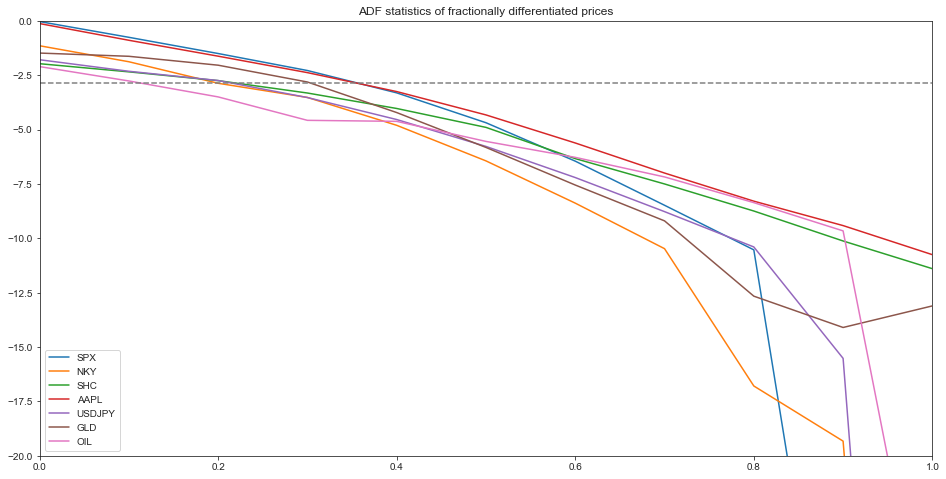

In [11]:
_, _, _, _, crit, _ = adfuller(prices['SPX'].values)
crit_5pc = crit['5%']

df_stats.plot(figsize=(16, 8), ylim=(-20, 0))
plt.axhline(y=crit_5pc, linestyle='--', color='gray')
plt.title('ADF statistics of fractionally differentiated prices')
plt.show()